## Check for Programmatic variations


check which hybrid performed best do we prefer precision or recall

In [9]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
noise = 'high'


golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')
eval_file = pd.read_csv("predicted_sameas_sorted.csv")

def extract_uuid(uri):
    return uri.split("/")[-1]

def extract_entity_type(uri):
    return uri.split("/")[-2]
eval_file['head_uuid'] = eval_file['head_label'].apply(extract_uuid)
eval_file['tail_uuid'] = eval_file['tail_label'].apply(extract_uuid)
eval_file['entity_type'] = eval_file['head_label'].apply(extract_entity_type)


eval_file.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,head_uuid,tail_uuid,entity_type
0,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,24,http://example.org/Address/1ae3237f-aa88-4965-...,-29.091862,014ef9de-b7ac-42bf-af2d-d0120447f7b5,1ae3237f-aa88-4965-9654-7b4d317588ff,Address
1,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,25,http://example.org/Address/1ba43eaf-84f4-4346-...,-29.065649,014ef9de-b7ac-42bf-af2d-d0120447f7b5,1ba43eaf-84f4-4346-9301-6d9e87d3b238,Address
2,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,26,http://example.org/Address/1c7bc6c8-d62f-4e8c-...,-26.688372,014ef9de-b7ac-42bf-af2d-d0120447f7b5,1c7bc6c8-d62f-4e8c-abca-09663eef04eb,Address
3,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,28,http://example.org/Address/21ab9e3d-fdf4-4f09-...,-27.908620,014ef9de-b7ac-42bf-af2d-d0120447f7b5,21ab9e3d-fdf4-4f09-bd87-d79311705ee3,Address
4,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,31,http://example.org/Address/25b09e48-1ca1-4fa7-...,-29.524300,014ef9de-b7ac-42bf-af2d-d0120447f7b5,25b09e48-1ca1-4fa7-83b8-bbaa7e24238e,Address


In [13]:
# Get all UUIDs from golden_standard (original_id and duplicate_id)
golden_uuids = set(golden_standard['original_id']).union(set(golden_standard['duplicate_id']))

# Get all UUIDs from eval_file (head_uuid and tail_uuid)
eval_uuids = set(eval_file['head_uuid']).union(set(eval_file['tail_uuid']))

# Find UUIDs in golden_standard not present in eval_file
missing_uuids = golden_uuids - eval_uuids

print(f"Number of UUIDs in golden_standard not present in eval_file: {len(missing_uuids)}")
if missing_uuids:
    print("Sample missing UUIDs:", list(missing_uuids)[:10])
else:
    print("All golden_standard UUIDs are present in eval_file.")


# Find golden_standard pairs where both IDs are missing from eval_file
# Create set of golden_standard pairs (order-agnostic)
golden_pairs = set(
    tuple(sorted([row['original_id'], row['duplicate_id']]))
    for _, row in golden_standard.iterrows()
)
missing_pairs_both_uuids = []
for id1, id2 in golden_pairs:
    if id1 in missing_uuids and id2 in missing_uuids:
        missing_pairs_both_uuids.append((id1, id2))

print(f"Number of golden_standard pairs where both IDs are missing from eval_file: {len(missing_pairs_both_uuids)}")
if missing_pairs_both_uuids:
    print("Sample pairs with both IDs missing:", missing_pairs_both_uuids[:10])
else:
    print("No golden_standard pairs found where both IDs are missing from eval_file.")





    # Remove rows from golden_standard where either original_id or duplicate_id is missing from eval_file
filtered_golden_standard = golden_standard[
    ~golden_standard['original_id'].isin(missing_uuids) &
    ~golden_standard['duplicate_id'].isin(missing_uuids)
].reset_index(drop=True)

print(f"Original golden_standard size: {len(golden_standard)}")
print(f"Filtered golden_standard size: {len(filtered_golden_standard)}")

Number of UUIDs in golden_standard not present in eval_file: 309
Sample missing UUIDs: ['db03dadf-a10f-4588-b1e1-9146f654f453', '745c759a-691f-4f9a-9895-89611d03e632', '0a671326-68dd-4e6f-ac93-fd83642e2475', '08e198e0-26aa-4d70-bcab-e955d5b99d72', '6bc9e970-c48a-4374-86dc-1579647640a1', '7634509e-e914-40e1-a5aa-9ba31c510adc', '59f391c2-5967-4ca8-b176-e3b619fd3977', 'a674ef4d-26ae-4093-8554-badbbe6ad0f7', '64a335b5-a973-439e-a2c9-b2627ed24723', '753f6426-15d7-4002-a974-d22825542d2a']
Number of golden_standard pairs where both IDs are missing from eval_file: 128
Sample pairs with both IDs missing: [('5171b7ad-fdfa-4d79-af7d-c2965f675adf', 'da47b8f9-cee4-4404-9648-1f4b0c747a90'), ('2595043b-9bdb-4a57-9126-974551a2ca34', 'c784499d-6909-4290-9496-a305314a332e'), ('443f88c7-533e-47af-a4bb-50577672a936', '5555ee5d-84b5-4c83-9eb8-3dd2a1dec0c1'), ('57ef40d4-35ac-440a-991d-c4be26616c41', 'a7176911-8230-488e-8b29-03f37d2c1e7e'), ('4d668807-a68f-4bb3-8cb6-cfc37e49eb8d', '8aeb3442-261e-4482-b1f5-68

Total pairs in eval_file: 226552
Total pairs in golden_standard: 507
Matched pairs: 363
Pairs in eval_file not in golden_standard: 226189
Pairs in golden_standard missing from eval_file: 144


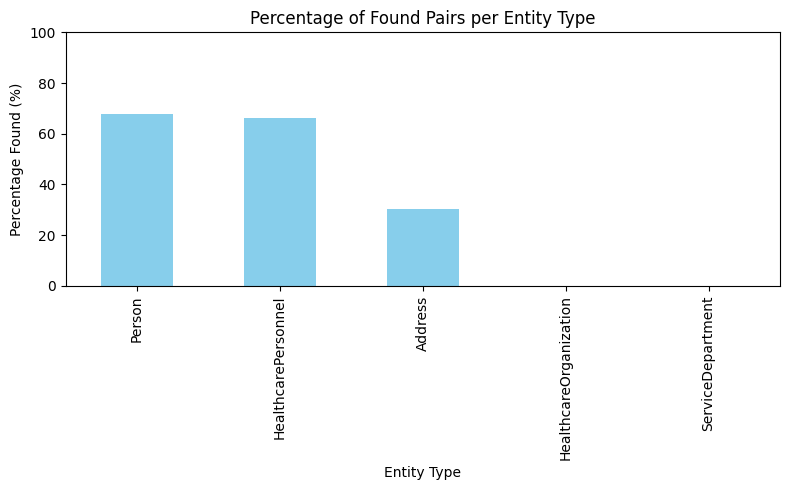

In [ ]:
# Compare head_uuid and tail_uuid pairs in eval_file with original_id and duplicate_id pairs in golden_standard

# Create sets of pairs for fast lookup (order-agnostic)
eval_pairs = set(
    tuple(sorted([row['head_uuid'], row['tail_uuid']]))
    for _, row in eval_file.iterrows()
)
golden_pairs = set(
    tuple(sorted([row['original_id'], row['duplicate_id']]))
    for _, row in filtered_golden_standard.iterrows()
)

# Find matches and misses
matched_pairs = eval_pairs & golden_pairs
unmatched_pairs = eval_pairs - golden_pairs 
missing_in_eval = golden_pairs - eval_pairs

print(f"Total pairs in eval_file: {len(eval_pairs)}")
print(f"Total pairs in golden_standard: {len(golden_pairs)}")
print(f"Matched pairs: {len(matched_pairs)}")
print(f"Pairs in eval_file not in golden_standard: {len(unmatched_pairs)}")
print(f"Pairs in golden_standard missing from eval_file: {len(missing_in_eval)}")
import matplotlib.pyplot as plt

# Calculate percentage of found (matched) pairs per entity type
total_by_entity = filtered_golden_standard['entity_type'].value_counts()
missed_by_entity = missed_rows['entity_type'].value_counts()
found_by_entity = total_by_entity - missed_by_entity
percent_found = (found_by_entity / total_by_entity * 100).sort_values(ascending=False)

# Plot
percent_found.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title('Percentage of Found Pairs per Entity Type')
plt.ylabel('Percentage Found (%)')
plt.xlabel('Entity Type')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [20]:
# Find golden_standard pairs that were NOT matched (i.e., missing in predictions)
# Use matched_pairs (set of predicted pairs) and golden_standard DataFrame

# Create set of golden standard pairs (order-agnostic)
golden_pairs_set = set(
    tuple(sorted([row['original_id'], row['duplicate_id']]))
    for _, row in filtered_golden_standard.iterrows()
)

# Find missing pairs: those in golden_standard but not in predictions
missed_pairs = golden_pairs_set - matched_pairs

# Optionally, get the rows from golden_standard corresponding to missed pairs
missed_rows = filtered_golden_standard[
    filtered_golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])) in missed_pairs,
        axis=1
    )
]

print(f"Number of missed golden_standard pairs: {len(missed_rows)}")
missed_rows

Number of missed golden_standard pairs: 225


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
0,b2b5591a-9d7f-442b-85e2-b0787a3e9905,dcb16933-8924-45a9-a1fe-f6e750d43367,Address,city_typo,city,Kattendijke,Kattedijke
1,d693bf11-7721-4931-9734-2123e3ed9637,ee9ebdf3-a93d-4c3c-9778-0cbce5ef89ef,Address,city_typo,city,Deursen-Dennenburg,Deursen-Dennennburg
2,eee13dc0-e1e4-49cf-8dba-6d8f7ab8572c,90b663a4-f57e-4453-afbe-2cbdc68ea7f7,Address,city_typo,city,Warstiens,Warstgiens
3,c44117e6-2c98-49d9-bd88-deb7fc584d66,107b9c81-eac2-4b70-b524-f5a864c8b521,Address,country_expansion,country,EE,Estonia
4,bb0378eb-7a62-422e-9d69-d9fc4b1cb8bd,6bb6d860-0e36-4879-9c8a-1a7c3c61aa78,Address,country_expansion,country,NL,Netherlands
...,...,...,...,...,...,...,...
739,db7ab001-c2c4-4958-8123-1a108b992df8,8285f062-852c-4aca-aae0-a6ec859a8fcc,HealthcarePersonnel,email_typo,email,alexishammond@healthcare.org,alexishammmond@healthcare.org
742,ab31993c-1359-40ef-b49a-a8bb1e84405d,7fbc5fb2-9b50-4c18-9728-c9e9e4912370,HealthcarePersonnel,email_typo,email,terryball@healthcare.org,tverryball@healthcare.org
744,c72c1863-a478-4863-91af-f050e1e610b0,97be6af8-70cf-49ed-a7ec-8e2194ad3308,HealthcarePersonnel,email_typo,email,shelbyleblanc@healthcare.org,shhelbyleblanc@healthcare.org
750,7bdc806d-ee19-4849-b6df-59df3569db32,f2c957d8-ce95-4828-aa1a-f668583a844c,HealthcarePersonnel,email_typo,email,markrhodes@healthcare.org,markrrhodes@healthcare.org


Missed pairs per entity_type:
entity_type
HealthcarePersonnel    107
Person                 102
Address                 16
Name: count, dtype: int64


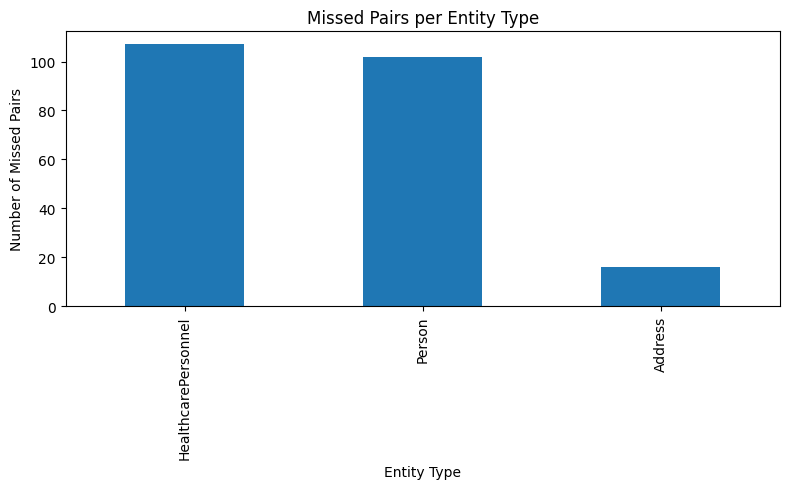

In [18]:
# Count missed pairs per entity_type using missed_rows DataFrame
missed_by_entity = missed_rows['entity_type'].value_counts().sort_values(ascending=False)
print("Missed pairs per entity_type:")
print(missed_by_entity)

# Optionally, plot the results
import matplotlib.pyplot as plt

missed_by_entity.plot(kind='bar', figsize=(8,5))
plt.title('Missed Pairs per Entity Type')
plt.xlabel('Entity Type')
plt.ylabel('Number of Missed Pairs')
plt.tight_layout()
plt.show()

In [5]:
eval_file.head()
#golden_standard.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,24,http://example.org/Address/1ae3237f-aa88-4965-...,-29.091862
1,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,25,http://example.org/Address/1ba43eaf-84f4-4346-...,-29.065649
2,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,26,http://example.org/Address/1c7bc6c8-d62f-4e8c-...,-26.688372
3,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,28,http://example.org/Address/21ab9e3d-fdf4-4f09-...,-27.908620
4,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,31,http://example.org/Address/25b09e48-1ca1-4fa7-...,-29.524300


Use the Best hybrid and compare the methods to one another


=== Sent_upgraded ===
Predicted pairs: 1200
True Duplicates Predicted: 147
True Positives: 570
False Positives: 489
False Negatives: 118
Precision: 0.5382
Recall: 0.8285
F1 Score: 0.6525

=== TransE.8 ===
Predicted pairs: 1207
True Duplicates Predicted: 150
True Positives: 581
False Positives: 482
False Negatives: 107
Precision: 0.5466
Recall: 0.8445
F1 Score: 0.6636

=== Distmult.5 ===
Predicted pairs: 1222
True Duplicates Predicted: 155
True Positives: 604
False Positives: 468
False Negatives: 84
Precision: 0.5634
Recall: 0.8779
F1 Score: 0.6864

=== NetMf.8 ===
Predicted pairs: 842
True Duplicates Predicted: 78
True Positives: 518
False Positives: 248
False Negatives: 170
Precision: 0.6762
Recall: 0.7529
F1 Score: 0.7125

=== Node2vec.8 ===
Predicted pairs: 1225
True Duplicates Predicted: 148
True Positives: 600
False Positives: 483
False Negatives: 88
Precision: 0.5540
Recall: 0.8721
F1 Score: 0.6776


Precision, Recall, F1 Score per Method:
               Precision  Recall  F1 Sco

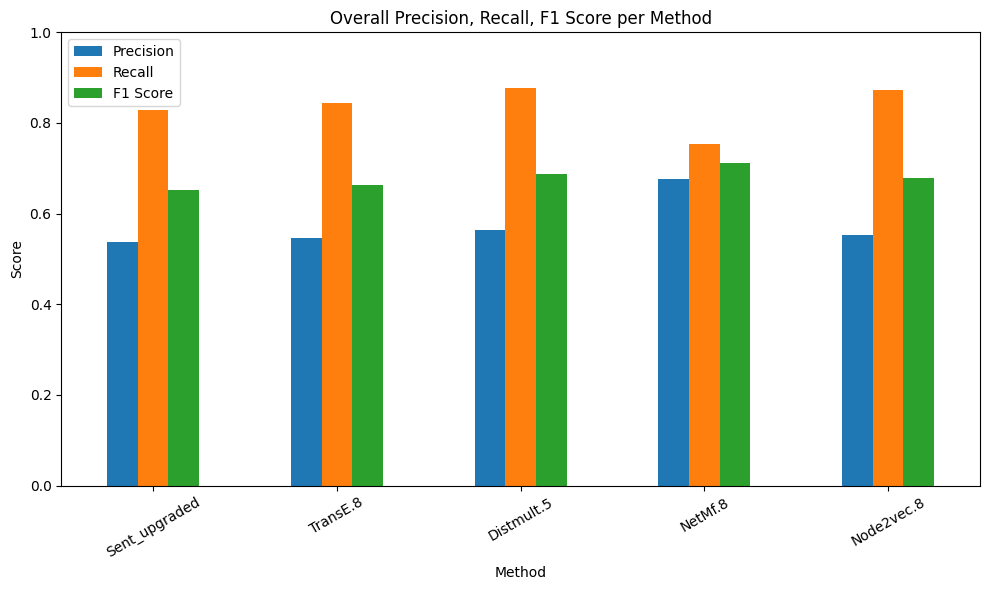

In [45]:
import pandas as pd
import json
import matplotlib.pyplot as plt

noise = 'high'
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

# Define which match files to analyze
match_files = {
    'Sent_upgraded': f'matches_{noise}/SentenceEmbedding.json',
    'TransE.8' : f'matches_{noise}/HybridTransE_alpha_0.8.json',
    'Distmult.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'NetMf.8' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec.8': f'matches_{noise}/HybridNode2vecLow_alpha_0.8.json',
}

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

precision_recall_summary = {}
percent_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Collect all predicted pairs & label exact matches in one pass ---
    pair_tuples = []
    true_dup_pairs = set()
    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        pair_tuples.append(pair)
        if match.get("duplication_type") == "true_duplicate":
            true_dup_pairs.add(pair)

    matched_pairs_set = set(pair_tuples)
    golden_pairs_set = set(
        tuple(sorted([row['original_id'], row['duplicate_id']]))
        for _, row in golden_standard.iterrows()
    )

    # -- Metrics: TP, FP (excluding true_duplicate not in golden), FN --
    TP = len(matched_pairs_set & golden_pairs_set)
    # Exclude predicted "exact/true_duplicate" pairs that are not in the golden set from FP
    FP = len((matched_pairs_set - golden_pairs_set) - true_dup_pairs)
    FN = len(golden_pairs_set - matched_pairs_set)

    predicted_not_in_golden = matched_pairs_set - golden_pairs_set
    true_duplicates_predicted = true_dup_pairs
    # Save in a summary dict for later
    if 'analysis' not in locals():
        analysis = {}
    analysis[match_type] = {
        'predicted_not_in_golden': list(predicted_not_in_golden),
        'true_duplicates_predicted': list(true_duplicates_predicted)}

    # # Optionally, also save to file for inspection
    # with open(f"{match_type}_predicted_not_in_golden.json", "w") as f:
    #     json.dump(list(predicted_not_in_golden), f)
    # with open(f"{match_type}_true_duplicates_predicted.json", "w") as f:
    #     json.dump(list(true_duplicates_predicted), f)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"=== {match_type} ===")
    print(f"Predicted pairs: {len(pair_tuples)}")
    print(f"True Duplicates Predicted: {sum(1 for match in data if match.get('duplication_type') == 'true_duplicate')}")
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1_score:.4f}\n")

    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    # --- Analysis by variation/entity type: use golden_standard, mark which pairs matched ---
    golden_standard['pair_key'] = golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])), axis=1)
    golden_standard['matched'] = golden_standard['pair_key'].isin(matched_pairs_set)

    # Variation-type analysis
    variation_stats = golden_standard.groupby('variation_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    variation_stats['Matched (%)'] = variation_stats['Matched_Count'] / variation_stats['Golden_Standard_Count'] * 100

    # Entity-type analysis
    entity_stats = golden_standard.groupby('entity_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    entity_stats['Matched (%)'] = entity_stats['Matched_Count'] / entity_stats['Golden_Standard_Count'] * 100

    # Combined variation/entity-type analysis
    combo_stats = golden_standard.groupby(['variation_type', 'entity_type']).agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    combo_stats['Matched (%)'] = combo_stats['Matched_Count'] / combo_stats['Golden_Standard_Count'] * 100
    combo_stats = combo_stats.reset_index().sort_values(['variation_type', 'entity_type'])

    # Save for plotting
    percent_summary[match_type] = entity_stats['Matched (%)']

    # (Optional: print for debugging)
    # print(variation_stats)
    # print(entity_stats)
    # print(combo_stats)

# --- Final Reporting and Plotting ---
pr_df = pd.DataFrame(precision_recall_summary).T.round(4)
print("\nPrecision, Recall, F1 Score per Method:")
print(pr_df)

# Barplot: Percentage of matched duplicates by entity type
pr_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Overall Precision, Recall, F1 Score per Method')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Number of missing golden_standard pairs: 118


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
65,ea5fe267-5877-4d3a-a8b5-a07a9659a673,49e76b10-eba7-4884-97df-e6d6bceb6d96,Address,country_expansion,country,AT,Austria
105,92d6ff73-5b3a-4595-8458-92c14e0e15d3,4d8244da-3e6f-4a18-9d76-d9ba4272fcff,HealthcareOrganization,name_abbreviation,healthcareOrganizationName,"Delgado, Guerrero and Simpson Zorg",DGS Zorg
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric
119,de9ac8b8-640b-4b28-8322-b4ff856df911,fc62388a-1bad-4a19-92c1-8e81c7351050,ServiceDepartment,translation,serviceDepartmentName,Renal,Nieren
126,6689ef79-f8c3-4461-bc15-b016487eb3df,a56e3fcc-d5c5-4f3a-8e10-a9dea407e939,ServiceDepartment,department_typo,serviceDepartmentName,Pediatric,Pldiatric
...,...,...,...,...,...,...,...
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord
923,fae3fcee-7636-4fd9-8376-ffa876fe579f,644064d5-1f21-49b4-8748-66303f5b02e8,ContactPoint,email_typo,email,PerezBecker@healthcare.org,PerzeBecker@healthcare.org
925,6efeb18f-aaa6-4ef9-bbb6-ba4c140ab78e,0a671326-68dd-4e6f-ac93-fd83642e2475,ContactPoint,translation,contactType,staff,personeel



Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall      F1
Address                    1.0000  0.9902  0.9951
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2731  0.6889  0.3912
Person                     1.0000  0.8228  0.9028
HealthcarePersonnel        1.0000  0.8481  0.9178
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for TransE.8:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2888  0.7444  0.4161
Person                     1.0000  0.8323  0.9085
HealthcarePersonnel        1.0000  0.8639  0.9270
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for Distmult.5:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.5000  1.000

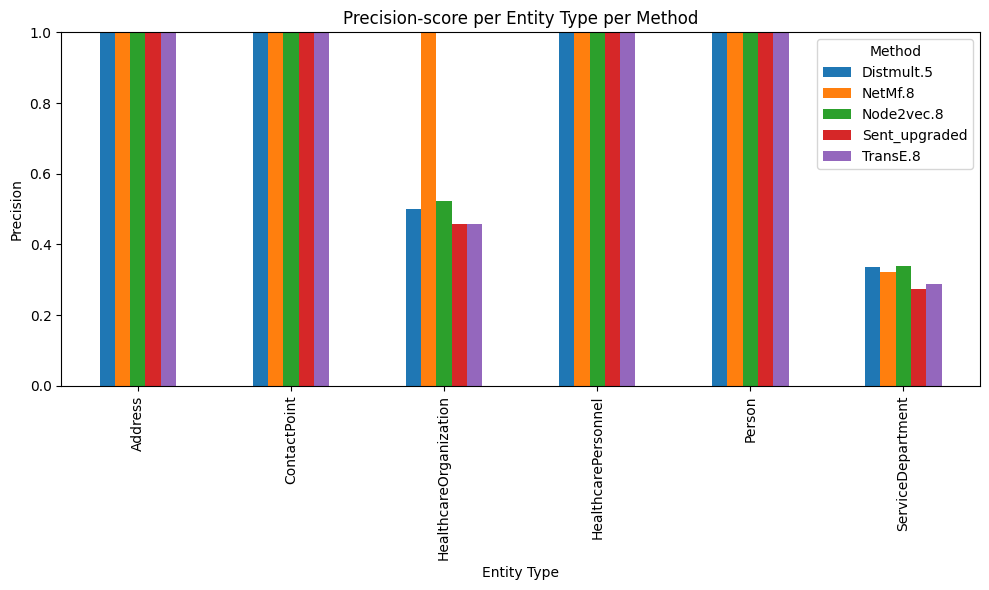

In [43]:

# -- Setup (same as before) --
noise = 'high'
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')
match_files = {
    'Sent_upgraded': f'matches_{noise}/SentenceEmbedding.json',
    'TransE.8' : f'matches_{noise}/HybridTransE_alpha_0.8.json',
    'Distmult.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'NetMf.8' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec.8': f'matches_{noise}/HybridNode2vecLow_alpha_0.8.json',
}

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

entity_type_pr_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Extract all predicted pairs and true_duplicate pairs once ---
    all_pairs = []
    all_pair_to_type = {}
    true_dup_pairs = set()

    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        all_pairs.append(pair)
        # Try to infer entity_type (from entity1 or entity2) if possible, or skip
        # (Here, you should store all types involved for later filtering)
        all_pair_to_type[pair] = None  # will filter per entity_type later
        if match.get("duplication_type") in ['true_duplicate', 'exact']:
            true_dup_pairs.add(pair)

    all_pairs_set = set(all_pairs)

    # -- Per-entity-type PRF calculation --
    prf_per_entity = {}
    entity_types = golden_standard['entity_type'].unique()

    for entity_type in entity_types:
        # Filter golden standard for this entity type
        gold_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        gold_type_pairs = set(tuple(sorted([row['original_id'], row['duplicate_id']]))
                              for _, row in gold_type_df.iterrows())
        valid_ids = set(gold_type_df['original_id']).union(set(gold_type_df['duplicate_id']))

        # Predicted pairs where both entities are of the current type
        pred_type_pairs = set(pair for pair in all_pairs_set if pair[0] in valid_ids and pair[1] in valid_ids)

        # Exclude "exact"/"true_duplicate" predictions not in golden for this entity type
        exact_not_in_golden = len([pair for pair in pred_type_pairs - gold_type_pairs if pair in true_dup_pairs])

        TP = len(pred_type_pairs & gold_type_pairs)
        FP = len(pred_type_pairs - gold_type_pairs) #- exact_not_in_golden
        FN = len(gold_type_pairs - pred_type_pairs)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}

    entity_type_pr_summary[match_type] = prf_per_entity

# -- To DataFrames and Display --
entity_prf_dfs = {method: pd.DataFrame(prf).T.round(4) for method, prf in entity_type_pr_summary.items()}

for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]
# print("\nCombined Precision/Recall/F1 per entity type:")
# print(combined_df)

# Plot Recall (change 'Recall' to 'F1' for F1 plot)
pivot_table = combined_df.pivot(index='Entity Type', columns='Method', values='Precision')
pivot_table.plot(kind='bar', figsize=(10,6))
plt.title('Precision-score per Entity Type per Method')
plt.ylabel('Precision')
plt.ylim(0,1)
plt.tight_layout()
plt.show()



Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall      F1
Address                    1.0000  0.9902  0.9951
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2731  0.6889  0.3912
Person                     1.0000  0.8228  0.9028
HealthcarePersonnel        1.0000  0.8481  0.9178
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for TransE.8:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2888  0.7444  0.4161
Person                     1.0000  0.8323  0.9085
HealthcarePersonnel        1.0000  0.8639  0.9270
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for Distmult.5:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.5000  1.000

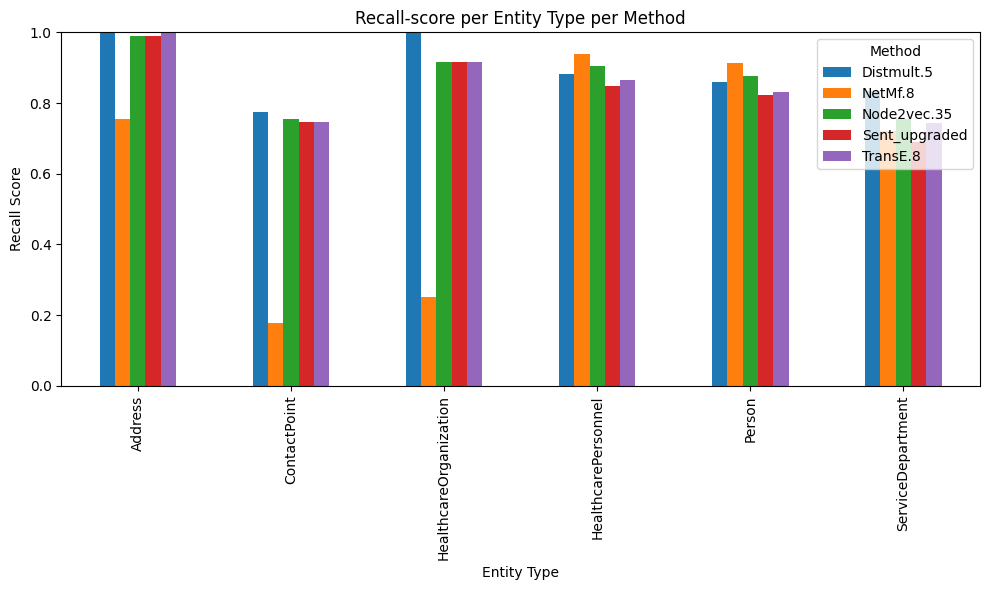

In [28]:
import pandas as pd
import json
import matplotlib.pyplot as plt

def extract_uuid(uri):
    return uri.split("/")[-1]

precision_recall_summary = {}
percent_summary = {}
entity_type_pr_summary = {}

for match_type, data in match_files.items():
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # === PER-ENTITY TYPE PRF computation ===
    prf_per_entity = {}

    # List of entity types in the golden standard
    entity_types = golden_standard['entity_type'].unique()
    # ...existing code...
    for entity_type in entity_types:
        # Filter golden pairs for this entity type
        golden_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        golden_pairs_set = set(
            (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
            for _, row in golden_type_df.iterrows()
        )
        valid_ids = set(golden_type_df['original_id']).union(set(golden_type_df['duplicate_id']))
        found_pairs_set = set(
            (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
            for pair in identifiers
            if pair['entity1'] in valid_ids and pair['entity2'] in valid_ids
        )

        # Find "exact" matches not in golden for this entity type
        exact_not_in_golden = 0
        for match in data:
            # Only consider matches for this entity type
            # (Assumes you have entity_type info in your match or can infer it)
            entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
            entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
            uuid1 = extract_uuid(entity1.get("subject"))
            uuid2 = extract_uuid(entity2.get("subject"))
            pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
            if uuid1 in valid_ids and uuid2 in valid_ids:
                if pair not in golden_pairs_set and match.get("duplication_type") == "true_duplicate":
                    exact_not_in_golden += 1

        TP = len(golden_pairs_set & found_pairs_set)
        FP = len(found_pairs_set - golden_pairs_set) - exact_not_in_golden
        FN = len(golden_pairs_set - found_pairs_set)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}
        entity_type_pr_summary[match_type] = prf_per_entity

# Convert results to DataFrames for nice display
entity_prf_dfs = {}
for method, prf_dict in entity_type_pr_summary.items():
    df = pd.DataFrame(prf_dict).T  # entity_type as index
    entity_prf_dfs[method] = df.round(4)

# Display all PRF tables for each method
for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

# If you want a combined table:
combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]


# You can also plot per-entity F1 for all methods
f1_table = combined_df.pivot(index='Entity Type', columns='Method', values='Recall')
f1_table.plot(kind='bar', figsize=(10,6))
plt.title('Recall-score per Entity Type per Method')
plt.ylabel('Recall Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [49]:
import pandas as pd
import json

# --- 1. Load golden standard and build id -> entity_type mapping ---
golden_standard = pd.read_csv('data/test_golden_standard_high.csv')
id_to_type = {}
for _, row in golden_standard.iterrows():
    id_to_type[row['original_id']] = row['entity_type']
    id_to_type[row['duplicate_id']] = row['entity_type']
all_golden_ids = set(id_to_type.keys())

# --- 2. Load predicted pairs (not in golden) ---
with open('error_analysis/Node2vec.8_predicted_not_in_golden.json', 'r') as f:
    pairs = json.load(f)

# --- 3. Check first identifier of each pair and collect entity type if matched ---
match_info = []
for pair in pairs:
    first_id = pair[0]
    if first_id in id_to_type:
        match_info.append({'id': first_id, 'entity_type': id_to_type[first_id], 'pair': pair})

# --- 4. Make a DataFrame and print entity type counts ---
df = pd.DataFrame(match_info)
print("Matched first identifiers by entity type:\n")
if not df.empty:
    print(df['entity_type'].value_counts())
    print("\nSample matches:\n", df.head())
else:
    print("No matches found for the given pairs.")


Matched first identifiers by entity type:

entity_type
ServiceDepartment         259
HealthcareOrganization     31
Name: count, dtype: int64

Sample matches:
                                      id             entity_type  \
0  09463e6f-3215-400e-a272-e2af92126ff1       ServiceDepartment   
1  76be8a0e-ed64-4bd1-a1b6-29a8fadd6ac1       ServiceDepartment   
2  7766f556-ce51-4ffc-943d-da2a7bacbd85       ServiceDepartment   
3  02246f10-ce65-4211-a3c9-c8d76ceb1865       ServiceDepartment   
4  5b87eb29-8f62-440c-a417-f1a31ec32201  HealthcareOrganization   

                                                pair  
0  [09463e6f-3215-400e-a272-e2af92126ff1, 46a6c03...  
1  [76be8a0e-ed64-4bd1-a1b6-29a8fadd6ac1, 798246e...  
2  [7766f556-ce51-4ffc-943d-da2a7bacbd85, e52bd55...  
3  [02246f10-ce65-4211-a3c9-c8d76ceb1865, 9711c99...  
4  [5b87eb29-8f62-440c-a417-f1a31ec32201, da98da5...  


In [46]:
# Find golden_standard pairs that were NOT matched by the current method (NetMf.8)
# Use the pair_tuples (predicted pairs) and golden_standard DataFrame

# Create set of predicted pairs for fast lookup
predicted_pairs_set = set(pair_tuples)

# Create set of golden standard pairs (order-agnostic)
golden_pairs_set = set(
    tuple(sorted([row['original_id'], row['duplicate_id']]))
    for _, row in golden_standard.iterrows()
)

# Find missing pairs: those in golden_standard but not in predictions
missing_pairs = golden_pairs_set - predicted_pairs_set

# Optionally, get the rows from golden_standard corresponding to missing pairs
missing_rows = golden_standard[
    golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])) in missing_pairs,
        axis=1
    )
]

print(f"Number of missing golden_standard pairs: {len(missing_rows)}")
missing_rows

Number of missing golden_standard pairs: 118


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value,pair_key,matched
65,ea5fe267-5877-4d3a-a8b5-a07a9659a673,49e76b10-eba7-4884-97df-e6d6bceb6d96,Address,country_expansion,country,AT,Austria,"(49e76b10-eba7-4884-97df-e6d6bceb6d96, ea5fe26...",False
105,92d6ff73-5b3a-4595-8458-92c14e0e15d3,4d8244da-3e6f-4a18-9d76-d9ba4272fcff,HealthcareOrganization,name_abbreviation,healthcareOrganizationName,"Delgado, Guerrero and Simpson Zorg",DGS Zorg,"(4d8244da-3e6f-4a18-9d76-d9ba4272fcff, 92d6ff7...",False
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric,"(bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78, fd85d57...",False
119,de9ac8b8-640b-4b28-8322-b4ff856df911,fc62388a-1bad-4a19-92c1-8e81c7351050,ServiceDepartment,translation,serviceDepartmentName,Renal,Nieren,"(de9ac8b8-640b-4b28-8322-b4ff856df911, fc62388...",False
126,6689ef79-f8c3-4461-bc15-b016487eb3df,a56e3fcc-d5c5-4f3a-8e10-a9dea407e939,ServiceDepartment,department_typo,serviceDepartmentName,Pediatric,Pldiatric,"(6689ef79-f8c3-4461-bc15-b016487eb3df, a56e3fc...",False
...,...,...,...,...,...,...,...,...,...
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine,"(b0ca76f7-17f9-4524-8332-ed33bba6e752, bc0e731...",False
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord,"(1d3976f9-6b44-49dc-ae74-13f04b65e378, 84ddf86...",False
923,fae3fcee-7636-4fd9-8376-ffa876fe579f,644064d5-1f21-49b4-8748-66303f5b02e8,ContactPoint,email_typo,email,PerezBecker@healthcare.org,PerzeBecker@healthcare.org,"(644064d5-1f21-49b4-8748-66303f5b02e8, fae3fce...",False
925,6efeb18f-aaa6-4ef9-bbb6-ba4c140ab78e,0a671326-68dd-4e6f-ac93-fd83642e2475,ContactPoint,translation,contactType,staff,personeel,"(0a671326-68dd-4e6f-ac93-fd83642e2475, 6efeb18...",False


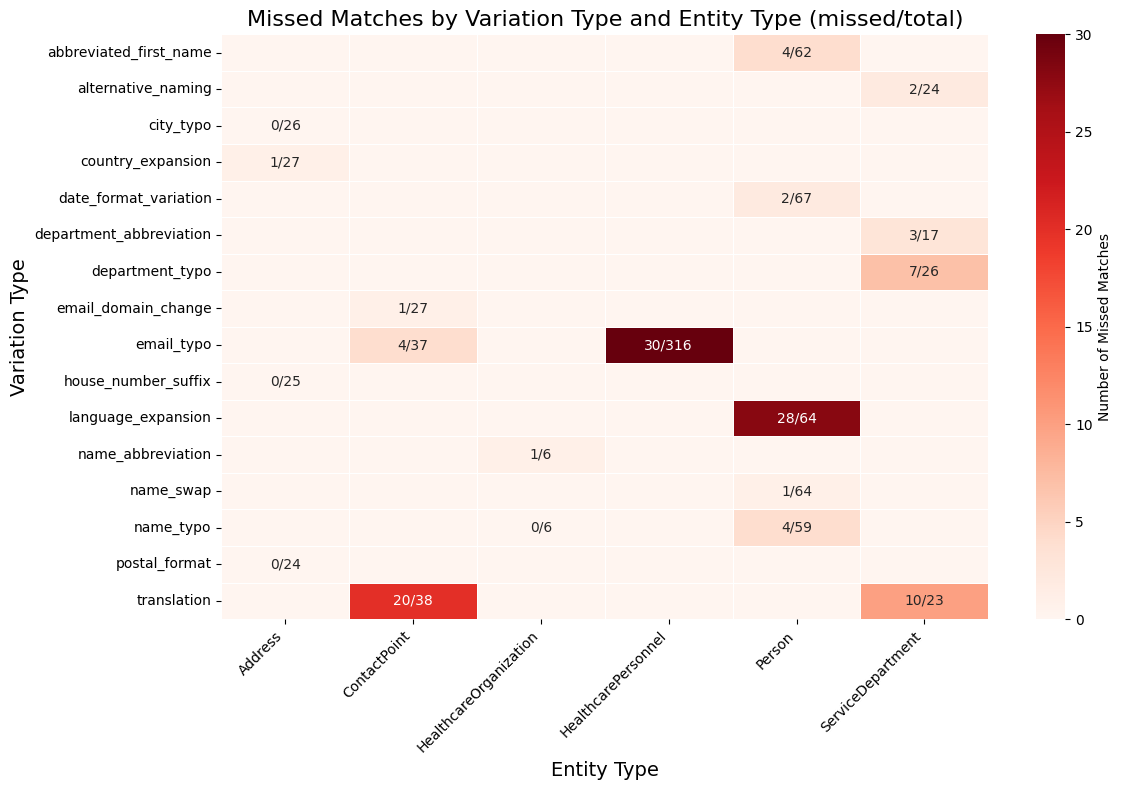

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missing_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)


# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()